# Intro

This is my solution to the [Airline Price Optimization Micro-Challenge](https://www.kaggle.com/dansbecker/airline-price-optimization-micro-challenge).  If you haven't tried the micro-challenge yourself, do it.  It is fun, you can create reasonably strong solutions in only 5 minutes, and you'll appreciate other solutions more if you try it yourself.


---

# Strategy

This solution uses an optimization technique called **dynamic programming**.  **Dynamic programming** starts by solving an optimization problem in a very limited scenario, and then creates an iterative rule to expand to larger problem.

In our case, we first solve for the optimal price when you only have 1 day to sell tickets before the flight.  Then we continually step back to longer time-horizons one day at a time.

This solution highlights two of the most important ideas from the fields of dynamic programming and reinforcement learning.  
- The **value function** returns the best outcome achievable from any input state.  In our case, **V(tickets_left, days_left)** returns the best revenue you can expect to achieve given the number of tickets you have and the number of days left before the flight.
-  The **Q Function** is similar to the value function. But it includes your decision as an input, and it returns the expected revenue even if that is not based on an optimal decision policy.

The distinction may become clearer when you see it in practice below. 

The output of the Q function for **T+1** days before the flight depends how much revenue is the sum of 
- revenue from flights sold that day
- revenue earned in the last **T** days from the remaining tickets.

Daily revenue is straightforward to calculate (as you'll see below.)  Since we calculate **Q** and the value function (denoted **V**) start near flight time, and then iteratively work backwards, we can look up revenue from the last **T** days from the value function.

Once we have **Q** at time T+1,  we calculate **V** on that day by looking up the revenue associated with the best decision from **Q**.

Again, this should become clearer as you see it in code.

# The Base Case: Selling Tickets For a Single Day

You want to maximize revenue, given the knowledge that 
> quantity_sold = demand_level - price

You may want to keep the price high rather than sell all remaining tickets. So, this problem is not as trivial as finding the price to sell all available tickets.  Instead, you will go back to find the price and quantity pair that maximize 
> revenue = price * quantity_sold

It's easier to think about optimization in terms of a single choice variable, rather than using an equation that explicitly includes both `price` and `quantity_sold`. To do this, first rearrange the `quantity_sold` equation above with simple algebra to solve for price:
> price = demand_level - quantity_sold

Plug this expression for price into the revenue equation and you have
> revenue = (demand_level - quantity_sold) * quantity_sold

*note: you could also express revenue entirely in terms of price instead of quantity, but would make a later steps a little messier.

Since `demand_level` is just a known number when you make your daily price decisions, you can plot revenue as an equation that depends only on the quantity you sell. 

For the sake of an example, here is the plot when `demand_level` is 150.


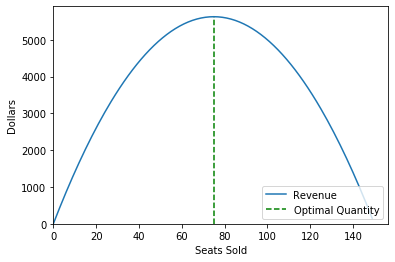

In [2]:
import matplotlib.pyplot as plt
import numpy as np

demand_level = 150
# only plot quantities up to demand_level. That's point where price becomes 0
revenue = [(demand_level - q) * q for q in range(demand_level)]

# Make primary plot
plt.plot(revenue, label="Revenue")
plt.xlabel("Seats Sold")
plt.ylabel("Dollars")
plt.ylim(ymin=0)
plt.xlim(xmin=0)

# Show the revenue maximizing quantity
optimal_q = np.argmax(revenue)
plt.vlines(x=optimal_q, ymin=0, ymax=max(revenue), color='green', linestyle="--", label="Optimal Quantity")

plt.legend(loc='lower right')
plt.show()

# Setting Up Q and V
Since the inputs to the V and Q functions take a limited number of values, we can store these function outputs in numpy arrays, indexed by the inputs. 

We'll include the `demand_level` as an input to Q, since that will affect your decision.  In practice, we use V to look up potential revenue for future days, and we won't know `demand_level` on those days when we do the lookup.  So, instead we will take an "expected value" by averaging over the future revenue from a range of demand levels.  For simplicity, we discretize the possible demand levels, calculating from a set of evenly spread values.

Here is the set-up code:

In [3]:
n_demand_levels = 11
min_demand_level = 100
max_demand_level = 200
demand_levels = np.linspace(min_demand_level, max_demand_level, n_demand_levels)

max_tickets = 200
max_days = 150

# Q indices are: n_sold in day, tickets_left to start day, demand_level, days_left
Q = np.zeros([max_tickets, max_tickets, n_demand_levels, max_days])
# V indices are: n_left and n_days
V = np.zeros([max_tickets, max_days])


# The Base Case: Selling With One Day Left
We then fill in Q values with `revenue = price * tickets_sold`.  Since this is the last day before the flight, we don't need to worry about future values.

The code for V is a little trickier than Q. So it is explained in the code comments.

In [4]:
for tickets_left in range(max_tickets):
    for tickets_sold in range(tickets_left+1): # add 1 to offset 0 indexing. Allow selling all tickets
        for demand_index, demand_level in enumerate(demand_levels):
            # Never set negative prices
            price = max(demand_level - tickets_sold, 0)
            Q[tickets_sold, tickets_left, demand_index, 0] = price * tickets_sold
    # For each demand_level, choose the optimum number to sell. Output of this is array .of size n_demand_levels
    revenue_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, 0].max(axis=0)
    # take the average, since we don't know demand level ahead of time and all are equally likely
    V[tickets_left, 0] = revenue_from_best_quantity_at_each_demand_level.mean()

# The General Case: Solving for Other Time Horizons
Now we iteratively calculate V and Q for time periods further back.  

The Q function now calculates current revenue as you saw above, but then adds the **V** of leftover tickets.


*note: for readibility, this code is not vectorized. It could likely be written to run faster.*

In [5]:
for days_left in range(1, max_days):
    for tickets_left in range(max_tickets):
        for tickets_sold in range(tickets_left):
            for demand_index, demand_level in enumerate(demand_levels):
                price = max(demand_level - tickets_sold, 0)
                rev_today = price * tickets_sold
                Q[tickets_sold, tickets_left, demand_index, days_left] = rev_today + V[tickets_left-tickets_sold, days_left-1]
        expected_total_rev_from_best_quantity_at_each_demand_level = Q[:, tickets_left, :, days_left].max(axis=0)
        V[tickets_left, days_left] = expected_total_rev_from_best_quantity_at_each_demand_level.mean()

We have **Q** and **V**.  How do we use them?

For any given number of tickets, days_left and demand_level, we look in **Q** to find the number of tickets with the highest Q-value.

Here is our pricing function that implements that:

In [6]:
def pricing_function(days_left, tickets_left, demand_level):
    demand_level_index = np.abs(demand_level - demand_levels).argmin()
    day_index = days_left - 1 # arrays are 0 indexed
    tickets_index = int(tickets_left)  # in case it comes in as float, but need to index with it
    relevant_Q_vals = Q[:, tickets_index, demand_level_index, day_index]
    desired_quantity = relevant_Q_vals.argmax()# offset 0 indexing
    price = demand_level - desired_quantity
    return price

And here is the score:

In [7]:
import sys
from flight_revenue_simulator import simulate_revenue, score_me

score_me(pricing_function)

Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: $18413
Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: $8492
Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: $2897
Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: $431


<IPython.core.display.Javascript object>

Average revenue across all flights is $7558


# The Challenge

If you beat $7558, let others know what you did by making your notebook public and posting a link in the comments.